In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df =pd.read_csv('./sample_datas/isods_forex/isods_train_small_1000.csv')
df

,Open,High,Low,Close,Volume,body,upper_tail,lower_tail,up_down
0,1.45865,1.45885,1.45856,1.45873,5004.3375,0.8,1.2,0.9,0
1,1.45883,1.45883,1.45847,1.45863,4649.9000,-2.0,0.0,1.6,1
2,1.45863,1.45896,1.45845,1.45886,5283.9500,2.3,1.0,1.8,1
3,1.45865,1.45905,1.45842,1.45895,5370.3375,3.0,1.0,2.3,0
4,1.45902,1.45905,1.45857,1.45887,3738.9375,-1.5,0.3,3.0,1
...,...,...,...,...,...,...,...,...,...
995,1.47687,1.47701,1.47598,1.47622,2200.4000,-6.5,1.4,2.4,1
996,1.47626,1.47678,1.47595,1.47632,1416.6000,0.6,4.6,3.1,1
997,1.47627,1.47709,1.47603,1.47692,1418.7000,6.5,1.7,2.4,1
998,1.47700,1.47756,1.47657,1.47732,1718.9000,3.2,2.4,4.3,0


In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=10, is_test = False):
    dataX, dataY_Regression, dataY_Classification = [], [], []
    
    if(is_test):
        X = dataset
    else:
        X = dataset[:,0:-1]
        Y_C = dataset[:,-1]
      
    if not (is_test):
        close = np.expand_dims(dataset[:,3], axis=1)
        close_scaler = MinMaxScaler(copy=True,feature_range=(0, 1))
        close_scaler.fit(close)    
        scaler = MinMaxScaler(copy=True,feature_range=(0, 1))
        X = scaler.fit_transform(X)
    
    for i in range(len(dataset)-look_back):
        if(is_test):
            a = X[i:(i+look_back),:]
            dataX.append(a)
            dataY_Regression.append(X[i + look_back, 3])
            
            if(i + look_back < len(X) - 1):
                if(X[i + look_back + 1, 3] > X[i + look_back, 3]): #TODO:
                    dataY_Classification.append([1,0])
                else:
                    dataY_Classification.append([0,1])
            else:
                dataY_Classification.append([1,0])       
        else:
            a = X[i:(i+look_back),:]
            dataX.append(a)
            dataY_Regression.append(X[i + look_back, 3])
            
            if(Y_C[i + look_back - 1] == 1):
                dataY_Classification.append([1,0])
            else:
                dataY_Classification.append([0,1])
    
    if (is_test):
        return np.array(dataX), np.array(dataY_Regression), np.array(dataY_Classification)
    else:
        return np.array(dataX), np.array(dataY_Regression), np.array(dataY_Classification), scaler, close_scaler

In [4]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [5]:
data_values = df.values
data_values = data_values.astype('float32')

In [6]:
X, Y_R, Y_C, scaler, close_scaler  = create_dataset(data_values, look_back=10)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, Y_C,test_size = 0.2)

In [23]:
from NeuralNet.Layers import *
from NeuralNet.Neuralnet import *
from NeuralNet.RNN import *
from NeuralNet.Optimizers import *

In [24]:
EPOCHS = 20
optimizer = Adam(0.0001)
loss_func = BinaryCrossEntropy()
archs = [
    Input(),
    SimpleRNN(512, return_sequences=True),
    Activation(activation="sigmoid"),
    SimpleRNN(128),
    Activation(activation="sigmoid"),
    Dropout(keep_prob=0.3),
    Dense(num_neurons=64, weight_init="glorot_normal"),
    Activation(activation="swish"),
    Dense(num_neurons=32, weight_init="glorot_normal", use_bias=True),
    Activation(activation="sigmoid"),
    Dense(num_neurons=2, weight_init="glorot_normal"),
    Activation(activation="softmax"),
]

In [25]:
val_set = (X_val, y_val)

model = Model(optimizer=optimizer, layers=archs, loss_func=loss_func)
train_losses, val_losses, train_accs, val_accs = model.fit(X_train, y_train, val_set, batch_size=64, epochs=EPOCHS)

import pickle
with open("isods_simple_2layers_rnn.pkl", "wb") as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

Epoch 1 - Loss: 0.76404: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
Loss at epoch 1: 0.76404 - Train accuracy: 0.49242 - Validation loss: 0.82168 - accuracy: 0.47475
Epoch 2 - Loss: 0.75637: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
Loss at epoch 2: 0.75637 - Train accuracy: 0.49242 - Validation loss: 0.81034 - accuracy: 0.47475
Epoch 3 - Loss: 0.74755: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]
Loss at epoch 3: 0.74755 - Train accuracy: 0.49242 - Validation loss: 0.79460 - accuracy: 0.47475
Epoch 4 - Loss: 0.73260: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s]
Loss at epoch 4: 0.73260 - Train accuracy: 0.49242 - Validation loss: 0.78009 - accuracy: 0.47475
Epoch 5 - Loss: 0.72848: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s]
Loss at epoch 5: 0.72848 - Train accuracy: 0.49242 - Validation loss: 0.77375 - accuracy: 0.47475
Epoch 6 - Loss: 0.72294: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]
Loss at epoch 6: 0.72294 - Train accuracy: 0.49242 - Validation loss: 0.

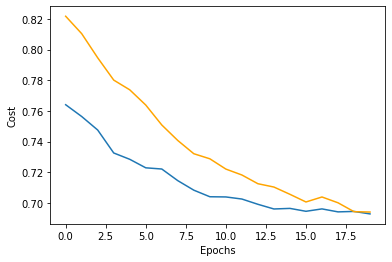

In [26]:
plt.plot(range(EPOCHS), train_losses, label='training')
plt.plot(range(EPOCHS), val_losses, label='validation', color='orange')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

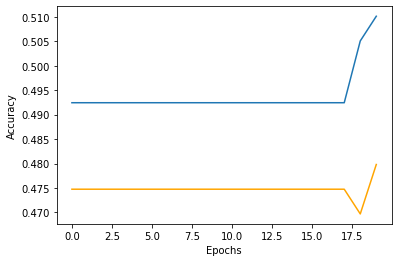

In [27]:
plt.plot(range(EPOCHS), train_accs, label='training')
plt.plot(range(EPOCHS), val_accs, label='validation', color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [28]:
pred = model.predict(X_val)
print("Accuracy:", len(pred[y_val[:,1] == pred]) / len(pred))
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_val[:,1], pred)

Accuracy: 0.4797979797979798


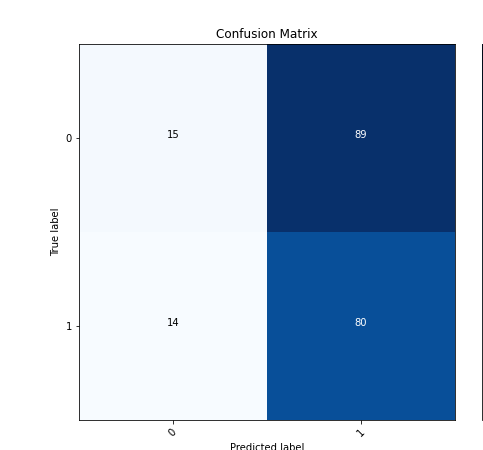

In [29]:
plot_confusion_matrix(cm           = array,
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix")